In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import numpy as np

import sys
sys.path.append('./../scripts')

from refuelplot import *
setup()
sns.set_style("darkgrid")

In [14]:
tx_path = '/data/projects/texas-power-outages/data/interim/'
fig_path = '/data/projects/texas-power-outages/data/figures/'
out_path = '/data/projects/texas-power-outages/data/output/'
fig_path_raw = fig_path+'raw_data/'

# load data

### load outages

In [3]:
reduction= pd.read_csv(tx_path+'outages/outages_reduction.csv',index_col=0,parse_dates=True).tz_convert('Etc/GMT+6')

### load load

In [4]:
# get load
load = pd.read_csv(tx_path + 'load/load_est_LR24temptrend_Hook-8.csv',index_col=0,parse_dates=True).tz_convert('Etc/GMT+6')
load70 = pd.read_csv(tx_path + 'load/load_est70_LR24_temptrend_Hook-8.csv',index_col=0,parse_dates=True).tz_convert('Etc/GMT+6')

### load temperature

In [12]:
# load power plant temperatures
temppp = pd.read_csv(tx_path + 'temperatures/temppowerplant.csv',index_col=0,parse_dates=True).tz_localize('UTC').tz_convert('Etc/GMT+6')

In [7]:
# load gas field temperatures
tempgf = pd.read_csv(tx_path + 'temperatures/temp_gasfields.csv',index_col=0,parse_dates=True).t2m.tz_convert('Etc/GMT+6')

In [9]:
# get temperature at windparks
tempwp = pd.read_csv(tx_path + 'temperatures/tempWP.csv',parse_dates=True,index_col=0).tz_convert('Etc/GMT+6').t2m
tempwpNS = pd.read_csv(tx_path + 'temperatures/tempWP_NSsplit.csv',parse_dates=True,index_col=0).tz_convert('Etc/GMT+6')

### load windpower

In [10]:
# get wind power
wp = pd.read_csv(tx_path + 'windpower/wpTXh.csv',parse_dates=True,index_col=0).tz_localize('UTC').tz_convert('Etc/GMT+6').wp

### load outage model results

In [8]:
out_model_param = pd.read_csv(out_path + 'outage_function_parameters/outage_function_parameters.cvs',index_col=0)

## threshold function

In [12]:
def get_thresh(temp,temp_fail,temp_recover,cap_loss,k):
    available_cap = pd.Series(0,index=temp.index)
    below_thresh = temp[temp<temp_fail].resample('M').count().replace(0,np.nan).dropna()
    ym = below_thresh.index.strftime("%Y-%m")
    h_recovery = int(-cap_loss/k)
    for i in range(len(below_thresh)):
        t1 = pd.to_datetime(ym[i])
        while(t1.strftime("%Y-%m")==ym[i]):
            t0 = (temp[t1:]<temp_fail).idxmax()
            try:
                t1 = (temp[(t0+np.timedelta64(10,'h')):]>temp_recover).idxmax()
            except:
                break
            const_time = int((t1-t0)/np.timedelta64(1,'h'))
            t2 = t1 + np.timedelta64(h_recovery-1,'h')
            available_cap[t0:t2] = cap_loss + k*np.concatenate([np.array([0]*const_time),np.arange(h_recovery)])[:len(available_cap[t0:t2])]
            if sum(temp[t1:]<temp_fail)==0:
                break
    return(available_cap)

# scenarios temp thresh

In [106]:
temppp.NG['2004':'2020'].min()

-8.019053888531824

## run scenarios

In [9]:
MAXOUT_GAS = round(out_model_param.outage_capacity.gas,1)
MAXOUT_WINDN = round(out_model_param.outage_capacity.wind_north,1)
MAXOUT_WINDS = round(out_model_param.outage_capacity.wind_south,1)
MAXOUT_COAL = round(out_model_param.outage_capacity.coal,1)
THRESH_GAS_TEMP = round(out_model_param.outage_temperature_threshold.gas,1)
THRESH_COAL_TEMP = round(out_model_param.outage_temperature_threshold.coal,1)
THRESH_WINDN_TEMP = round(out_model_param.outage_temperature_threshold.wind_north,1)
THRESH_WINDS_TEMP = round(out_model_param.outage_temperature_threshold.wind_south,1)

REC_GAS_TEMP = round(out_model_param.recovery_temperature_threshold.gas,1)
REC_COAL_TEMP = round(out_model_param.recovery_temperature_threshold.coal,1)
REC_WINDN_TEMP = round(out_model_param.recovery_temperature_threshold.wind_north,1)
REC_WINDS_TEMP = round(out_model_param.recovery_temperature_threshold.wind_south,1)

K_GAS = -out_model_param.outage_capacity.gas/out_model_param.recovery_length.gas
K_COAL = -out_model_param.outage_capacity.coal/out_model_param.recovery_length.coal
K_WINDN = -out_model_param.outage_capacity.wind_north/out_model_param.recovery_length.wind_north
K_WINDS = -out_model_param.outage_capacity.wind_south/out_model_param.recovery_length.wind_south

### variation of gas temperature threshold

calculate wind and coal thresholds before to save time

In [14]:
thresh_windN = get_thresh(tempwpNS.t2mNorth,THRESH_WINDN_TEMP,REC_WINDN_TEMP,MAXOUT_WINDN,K_WINDN)
thresh_windS = get_thresh(tempwpNS.t2mSouth,THRESH_WINDS_TEMP,REC_WINDS_TEMP,MAXOUT_WINDS,K_WINDS)
wp_remain = wp/10**6*(33-thresh_windN-thresh_windS)/33
thresh_coal = get_thresh(temppp.COAL,THRESH_COAL_TEMP,REC_COAL_TEMP,MAXOUT_COAL,K_COAL)

In [24]:
def run_scenario_temp_gas(thresh_gas_temp,rec_gas_temp,wp_remain,thresh_coal):
    # GET THRESHOLDS
    thresh_gas = get_thresh(temppp.NG,thresh_gas_temp,rec_gas_temp,MAXOUT_GAS,K_GAS)
    thresh_gas_coal = 63.5 - (thresh_gas + thresh_coal)
    thresh_total = thresh_gas_coal + wp_remain

    loss = (load70.load_est/1000 - thresh_total)[(load70.load_est/1000 - thresh_total)>0]/1000
    events = loss.resample('Y').sum().replace(0,np.nan).dropna()
    total_loss = loss.sum()
    mean_loss = loss.sum()/len(events)
    rank2021 = np.where(events.sort_values(ascending=False).index.year==2021)[0][0]

    res = pd.DataFrame({'thresh_gas_temp':thresh_gas_temp,
                        'rec_gas_temp':rec_gas_temp,
                        'number_of_events':len(events),
                        'after2004':[events['2004':].index.year.values],
                        'total_loss_TWh':total_loss,
                        'max_loss_GW':loss.max(),
                        'mean_loss_GW':mean_loss,
                        'mean_revenue_mioUSD':mean_loss*9,
                        'rank_2021_event':rank2021})
            
    return(res)

In [25]:
if 'scen_res_temp_gas' in globals():
    del(scen_res_temp_gas)
for gast in THRESH_GAS_TEMP - np.array(range(-6,7))/2:
    for rect in REC_GAS_TEMP - np.array(range(-3,4))/2:
        new_res = run_scenario_temp_gas(gast,rect,wp_remain,thresh_coal)
        if 'scen_res_temp_gas' in globals():
            scen_res_temp_gas = pd.concat([scen_res_temp_gas,new_res],axis=0)
        else:
            scen_res_temp_gas = new_res

In [26]:
# fix decimal error
scen_res_temp_gas['thresh_gas_temp'] = round(scen_res_temp_gas.thresh_gas_temp,1)
scen_res_temp_gas['rec_gas_temp'] = round(scen_res_temp_gas.rec_gas_temp,1)

In [27]:
scen_res_temp_gas.to_csv(out_path + 'sensitivity_analysis_temperature_thresholds_gas_LR24temptrend_Hook-8.csv')

In [29]:
scen_res_temp_gas[(scen_res_temp_gas.thresh_gas_temp==THRESH_GAS_TEMP)&(scen_res_temp_gas.rec_gas_temp==REC_GAS_TEMP)]

,thresh_gas_temp,rec_gas_temp,number_of_events,after2004,total_loss_TWh,max_loss_GW,mean_loss_GW,mean_revenue_mioUSD,rank_2021_event
0,-8.8,0.0,23,"[2010, 2011, 2018, 2021]",7.655184,0.031255,0.332834,2.995507,0


### variation of coal temperature threshold

calculate gas threshold before to save time

In [15]:
thresh_gas = get_thresh(temppp.NG,THRESH_GAS_TEMP,REC_GAS_TEMP,MAXOUT_GAS,K_GAS)

In [54]:
def run_scenario_temp_coal(thresh_coal_temp,rec_coal_temp,wp_remain,thresh_gas):
    # GET THRESHOLDS
    thresh_coal = get_thresh(temppp.COAL,thresh_coal_temp,rec_coal_temp,MAXOUT_COAL,K_COAL)
    thresh_gas_coal = 63.5 - (thresh_gas + thresh_coal)
    thresh_total = thresh_gas_coal + wp_remain

    loss = (load70.load_est/1000 - thresh_total)[(load70.load_est/1000 - thresh_total)>0]/1000
    events = loss.resample('Y').sum().replace(0,np.nan).dropna()
    total_loss = loss.sum()
    mean_loss = loss.sum()/len(events)
    rank2021 = np.where(events.sort_values(ascending=False).index.year==2021)[0][0]


    res = pd.DataFrame({'thresh_coal_temp':thresh_coal_temp,
                        'rec_coal_temp':rec_coal_temp,
                        'number_of_events':len(events),
                        'after2004':[events['2004':].index.year.values],
                        'total_loss_TWh':total_loss,
                        'max_loss_GW':loss.max(),
                        'mean_loss_GW':mean_loss,
                        'mean_revenue_mioUSD':mean_loss*9,
                        'rank_2021_event':rank2021})
            
    return(res)

In [55]:
if 'scen_res_temp_coal' in globals():
    del(scen_res_temp_coal)
for coalt in THRESH_COAL_TEMP - np.array(range(-6,7))/2:
    for rect in REC_COAL_TEMP - np.array(range(-3,4))/2:
        new_res = run_scenario_temp_coal(coalt,rect,wp_remain,thresh_gas)
        if 'scen_res_temp_coal' in globals():
            scen_res_temp_coal = pd.concat([scen_res_temp_coal,new_res],axis=0)
        else:
            scen_res_temp_coal = new_res

In [56]:
# fix decimal error
scen_res_temp_coal['thresh_coal_temp'] = round(scen_res_temp_coal.thresh_coal_temp,1)
scen_res_temp_coal['rec_coal_temp'] = round(scen_res_temp_coal.rec_coal_temp,1)

In [57]:
scen_res_temp_coal.to_csv(out_path + 'sensitivity_analysis_temperature_thresholds_coal_LR24temptrend_Hook-8.csv')

### variation of wind north temperature thresholds

prepare thermal threshold

In [16]:
thresh_gas_coal = 63.5 - (thresh_gas + thresh_coal)

In [58]:
def run_scenario_temp_wind_north(thresh_windn_temp,rec_windn_temp,thresh_gas_coal,thresh_windS):
    # GET THRESHOLDS
    thresh_windN = get_thresh(tempwpNS.t2mNorth,thresh_windn_temp,rec_windn_temp,MAXOUT_WINDN,K_WINDN)
    wp_remain = wp/10**6*(33-thresh_windN-thresh_windS)/33
    thresh_total = thresh_gas_coal + wp_remain

    loss = (load70.load_est/1000 - thresh_total)[(load70.load_est/1000 - thresh_total)>0]/1000
    events = loss.resample('Y').sum().replace(0,np.nan).dropna()
    total_loss = loss.sum()
    mean_loss = loss.sum()/len(events)
    rank2021 = np.where(events.sort_values(ascending=False).index.year==2021)[0][0]

    res = pd.DataFrame({'thresh_windn_temp':thresh_windn_temp,
                        'rec_windn_temp':rec_windn_temp,
                        'number_of_events':len(events),
                        'after2004':[events['2004':].index.year.values],
                        'total_loss_TWh':total_loss,
                        'max_loss_GW':loss.max(),
                        'mean_loss_GW':mean_loss,
                        'mean_revenue_mioUSD':mean_loss*9,
                        'rank_2021_event':rank2021})
            
    return(res)

for wind in north, different than for other technologies, we do not vary the threshold temperature between a +/-3°C area to avoid positive temperature thresholds; instead we use the range -5°C to +1°C around the original threshold

In [59]:
if 'scen_res_temp_windn' in globals():
    del(scen_res_temp_windn)
for windnt in THRESH_WINDN_TEMP - np.array(range(-2,11))/2:
    for rect in REC_WINDN_TEMP - np.array(range(-3,4))/2:
        new_res = run_scenario_temp_wind_north(windnt,rect,thresh_gas_coal,thresh_windS)
        if 'scen_res_temp_windn' in globals():
            scen_res_temp_windn = pd.concat([scen_res_temp_windn,new_res],axis=0)
        else:
            scen_res_temp_windn = new_res

In [60]:
# fix decimal error
scen_res_temp_windn['thresh_windn_temp'] = round(scen_res_temp_windn.thresh_windn_temp,1)
scen_res_temp_windn['rec_windn_temp'] = round(scen_res_temp_windn.rec_windn_temp,1)

In [61]:
scen_res_temp_windn.to_csv(out_path + 'sensitivity_analysis_temperature_thresholds_wind_north_LR24temptrend_Hook-8.csv')

### variation of wind south temperature thresholds

In [62]:
def run_scenario_temp_wind_south(thresh_winds_temp,rec_winds_temp,thresh_gas_coal,thresh_windN):
    # GET THRESHOLDS
    thresh_windS = get_thresh(tempwpNS.t2mSouth,thresh_winds_temp,rec_winds_temp,MAXOUT_WINDS,K_WINDS)
    wp_remain = wp/10**6*(33-thresh_windN-thresh_windS)/33
    thresh_total = thresh_gas_coal + wp_remain

    loss = (load70.load_est/1000 - thresh_total)[(load70.load_est/1000 - thresh_total)>0]/1000
    events = loss.resample('Y').sum().replace(0,np.nan).dropna()
    total_loss = loss.sum()
    mean_loss = loss.sum()/len(events)
    rank2021 = np.where(events.sort_values(ascending=False).index.year==2021)[0][0]

    res = pd.DataFrame({'thresh_winds_temp':thresh_winds_temp,
                        'rec_winds_temp':rec_winds_temp,
                        'number_of_events':len(events),
                        'after2004':[events['2004':].index.year.values],
                        'total_loss_TWh':total_loss,
                        'max_loss_GW':loss.max(),
                        'mean_loss_GW':mean_loss,
                        'mean_revenue_mioUSD':mean_loss*9,
                        'rank_2021_event':rank2021})
            
    return(res)

In [63]:
if 'scen_res_temp_winds' in globals():
    del(scen_res_temp_winds)
for windst in THRESH_WINDS_TEMP - np.array(range(-6,7))/2:
    for rect in REC_WINDS_TEMP - np.array(range(-3,4))/2:
        new_res = run_scenario_temp_wind_south(windst,rect,thresh_gas_coal,thresh_windN)
        if 'scen_res_temp_winds' in globals():
            scen_res_temp_winds = pd.concat([scen_res_temp_winds,new_res],axis=0)
        else:
            scen_res_temp_winds = new_res

In [64]:
# fix decimal error
scen_res_temp_winds['thresh_winds_temp'] = round(scen_res_temp_winds.thresh_winds_temp,1)
scen_res_temp_winds['rec_winds_temp'] = round(scen_res_temp_winds.rec_winds_temp,1)

In [65]:
scen_res_temp_winds.to_csv(out_path + 'sensitivity_analysis_temperature_thresholds_wind_south_LR24temptrend_Hook-8.csv')

### variation of all temperature thresholds simultaneously 

In [17]:
def run_scenario_temp_all(temps):
    delta_thresh_temp = temps.delta_thresh
    delta_rec_temp = temps.delta_rec
    # GET THRESHOLD TEMPERATURES
    thresh_gas_temp = THRESH_GAS_TEMP + delta_thresh_temp
    rec_gas_temp = REC_GAS_TEMP + delta_rec_temp
    thresh_coal_temp = THRESH_COAL_TEMP + delta_thresh_temp
    rec_coal_temp = REC_COAL_TEMP + delta_rec_temp
    thresh_windn_temp = THRESH_WINDN_TEMP + delta_thresh_temp
    rec_windn_temp = REC_WINDN_TEMP + delta_rec_temp
    thresh_winds_temp = THRESH_WINDS_TEMP + delta_thresh_temp
    rec_winds_temp = REC_WINDS_TEMP + delta_rec_temp
    
    # GET THRESHOLDS
    thresh_gas = get_thresh(temppp.NG,thresh_gas_temp,rec_gas_temp,MAXOUT_GAS,K_GAS)
    thresh_coal = get_thresh(temppp.COAL,thresh_coal_temp,rec_coal_temp,MAXOUT_COAL,K_COAL)
    thresh_gas_coal = 63.5 - (thresh_gas + thresh_coal)
    #print(thresh_windn_temp,rec_windn_temp)
    thresh_windN = get_thresh(tempwpNS.t2mNorth,thresh_windn_temp,rec_windn_temp,MAXOUT_WINDN,K_WINDN)
    thresh_windS = get_thresh(tempwpNS.t2mSouth,thresh_winds_temp,rec_winds_temp,MAXOUT_WINDS,K_WINDS)
    wp_remain = wp/10**6*(33-thresh_windN-thresh_windS)/33
    thresh_total = thresh_gas_coal + wp_remain

    loss = (load70.load_est/1000 - thresh_total)[(load70.load_est/1000 - thresh_total)>0]/1000
    events = loss.resample('Y').sum().replace(0,np.nan).dropna()
    total_loss = loss.sum()
    mean_loss = loss.sum()/len(events)
    rank2021 = np.where(events.sort_values(ascending=False).index.year==2021)[0][0]

    res = pd.DataFrame({'delta_thresh_temp':delta_thresh_temp,
                        'delta_rec_temp':delta_rec_temp,
                        'number_of_events':len(events),
                        'after2004':[events['2004':].index.year.values],
                        'total_loss_TWh':total_loss,
                        'max_loss_GW':loss.max(),
                        'mean_loss_GW':mean_loss,
                        'mean_revenue_mioUSD':mean_loss*9,
                        'rank_2021_event':rank2021})
            
    return(res)

In [18]:
deltas = pd.DataFrame(np.array(np.meshgrid(np.arange(-6,7)/2,
                                           np.arange(-3,4)/2)).T.reshape(-1,2),
                      columns = ['delta_thresh','delta_rec'])

In [19]:
scen_res_temp_all = deltas.apply(run_scenario_temp_all,axis=1)
scen_res_temp_all = pd.concat(scen_res_temp_all.to_list(),axis=0)

In [21]:
scen_res_temp_all.to_csv(out_path + 'sensitivity_analysis_temperature_thresholds_all_LR24temptrend_Hook-8.csv')

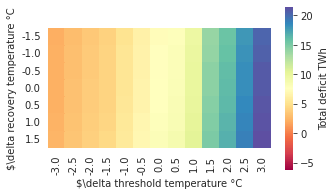

In [22]:
(fig,ax1)=plt.subplots(1,1,figsize=(5,3))

minloss = scen_res_temp_all.total_loss_TWh.min()
maxloss = scen_res_temp_all.total_loss_TWh.max()
baseloss = scen_res_temp_all[(scen_res_temp_all.delta_thresh_temp==0)&(scen_res_temp_all.delta_rec_temp==0)].total_loss_TWh.values
maxdif = max(maxloss-baseloss,baseloss-minloss)

sns.heatmap(scen_res_temp_all[['delta_thresh_temp','delta_rec_temp','total_loss_TWh']].pivot(index='delta_rec_temp', columns='delta_thresh_temp')['total_loss_TWh'],
            ax=ax1,cmap='Spectral',vmin=baseloss-maxdif,vmax=baseloss+maxdif,
            square=True,cbar_kws={'label': 'Total deficit TWh'})
ax1.set_xlabel(r'$\delta threshold temperature °C')
ax1.set_ylabel(r'$\delta recovery temperature °C')
#ax1.set_title('Total deficit TWh')

plt.savefig(fig_path + 'sensitivity_temp_all_LR24temptrend_Hook-8.pdf',dpi=300)

### gas + simulatenously

In [5]:
scen_res_temp_all = pd.read_csv(out_path + 'sensitivity_analysis_temperature_thresholds_all_LR24temptrend_Hook-8.csv')
scen_res_temp_gas = pd.read_csv(out_path + 'sensitivity_analysis_temperature_thresholds_gas_LR24temptrend_Hook-8.csv')

In [16]:
scen_res_temp_gas.to_csv(fig_path_raw + 'FigA3_gas.csv')
scen_res_temp_all.to_csv(fig_path_raw + 'FigA3_all.csv')

In [10]:
minloss = min(scen_res_temp_gas.total_loss_TWh.min(),scen_res_temp_all.total_loss_TWh.min())
maxloss = max(scen_res_temp_gas.total_loss_TWh.max(),scen_res_temp_all.total_loss_TWh.max())
baseloss = scen_res_temp_gas[(scen_res_temp_gas.thresh_gas_temp==THRESH_GAS_TEMP)&(scen_res_temp_gas.rec_gas_temp==REC_GAS_TEMP)].total_loss_TWh.values
maxdif = max(maxloss-baseloss,baseloss-minloss)

In [41]:
temppp.NG['2011':'2020'].resample('Y').min().sort_values()[:9]#.values

2018-12-31 00:00:00-06:00   -8.019054
2011-12-31 00:00:00-06:00   -7.701274
2017-12-31 00:00:00-06:00   -7.324994
2014-12-31 00:00:00-06:00   -5.692025
2016-12-31 00:00:00-06:00   -4.022334
2015-12-31 00:00:00-06:00   -3.634140
2019-12-31 00:00:00-06:00   -2.878763
2013-12-31 00:00:00-06:00   -2.113905
2012-12-31 00:00:00-06:00   -1.782447
Name: NG, dtype: float64

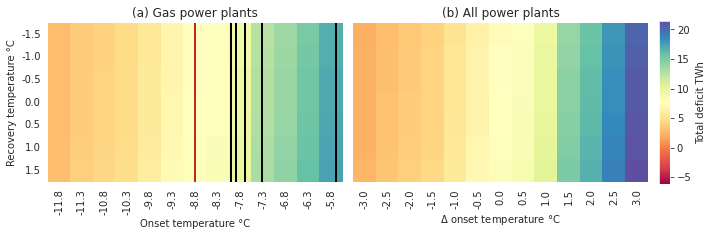

In [13]:
#(fig,(ax1,ax2))=plt.subplots(1,2,figsize=(11,4))
(fig,(ax1,ax2,ax3))=plt.subplots(1,3,figsize=(10,3), gridspec_kw=dict(width_ratios=[5.4,5.4,0.2]))#5.9,0.2]))


minloss = min(scen_res_temp_gas.total_loss_TWh.min(),scen_res_temp_all.total_loss_TWh.min())
maxloss = max(scen_res_temp_gas.total_loss_TWh.max(),scen_res_temp_all.total_loss_TWh.max())
baseloss = scen_res_temp_gas[(scen_res_temp_gas.thresh_gas_temp==THRESH_GAS_TEMP)&(scen_res_temp_gas.rec_gas_temp==REC_GAS_TEMP)].total_loss_TWh.values
maxdif = max(maxloss-baseloss,baseloss-minloss)

sns.heatmap(scen_res_temp_gas[['thresh_gas_temp','rec_gas_temp','total_loss_TWh']].pivot(index='rec_gas_temp', columns='thresh_gas_temp')['total_loss_TWh'],
            ax=ax1,cmap='Spectral',vmin=baseloss-maxdif,vmax=baseloss+maxdif,
            square=True,cbar=False)
ax1.set_xlabel('Onset temperature °C')
ax1.set_ylabel('Recovery temperature °C')
ax1.set_title('(a) Gas power plants')

# plot lowest temperatures within 7 decades
#lowest_temperatures = temppp.NG['2011':'2020'].resample('Y').min().sort_values()[:3].values
lowest_temperatures = temppp.NG['2004':'2020'].resample('Y').min().sort_values().values
# calculate lowest temperatures on scale
lims = ax1.get_xlim()
k = (lims[1]-1)/(scen_res_temp_gas.thresh_gas_temp.max()-scen_res_temp_gas.thresh_gas_temp.min())
d = 0.5-k*scen_res_temp_gas.thresh_gas_temp.min()
for lt in lowest_temperatures:
    x = k*lt+d
    ax1.vlines(x,*ax1.get_ylim(),colors='black',lw=2)
ax1.vlines(k*-8.8+d,*ax1.get_ylim(),colors=COLORS[0],lw=2)



sns.heatmap(scen_res_temp_all[['delta_thresh_temp','delta_rec_temp','total_loss_TWh']].pivot(index='delta_rec_temp', columns='delta_thresh_temp')['total_loss_TWh'],
            ax=ax2,cmap='Spectral',vmin=baseloss-maxdif,vmax=baseloss+maxdif,
            square=True,cbar=False)#,cbar_kws={'label': 'Total deficit TWh'})
ax2.set_xlabel(r'$\Delta$ onset temperature °C')
#ax2.set_ylabel(r'$\delta recovery temperature °C')
ax2.set_ylabel('')
ax2.set_title('(b) All power plants')
ax2.set_yticklabels([])

fig.colorbar(ax2.collections[0], cax=ax3)
ax3.set_ylabel('Total deficit TWh')
fig.tight_layout()

plt.savefig(fig_path + 'sensitivity_temp_gas+all_LR24temptrend_Hook-8.pdf',dpi=300,bbox_inches='tight')

In [17]:
pd.Series(lowest_temperatures).to_csv(fig_path_raw + 'FigA3_lowest_temperatures.csv')

##### get results

In [33]:
print(round(scen_res_temp_gas[(scen_res_temp_gas.thresh_gas_temp==-8.8)].total_loss_TWh.min(),2))
print(round(scen_res_temp_gas[(scen_res_temp_gas.thresh_gas_temp==-8.8)].total_loss_TWh.max(),2))
print(round(scen_res_temp_gas[(scen_res_temp_gas.thresh_gas_temp==-7.8)].total_loss_TWh.min(),2))
print(round(scen_res_temp_gas[(scen_res_temp_gas.thresh_gas_temp==-7.8)].total_loss_TWh.max(),2))

7.57
8.05
9.37
9.95


In [53]:
print(round(scen_res_temp_gas[(scen_res_temp_gas.thresh_gas_temp==-8.8)].total_loss_TWh.min(),2))
print(round(scen_res_temp_gas[(scen_res_temp_gas.thresh_gas_temp==-8.8)].total_loss_TWh.max(),2))
print(round((scen_res_temp_gas[(scen_res_temp_gas.thresh_gas_temp==-7.8)].total_loss_TWh.min()*3+
            scen_res_temp_gas[(scen_res_temp_gas.thresh_gas_temp==-8.3)].total_loss_TWh.min()*2)/5,2))
print(round((scen_res_temp_gas[(scen_res_temp_gas.thresh_gas_temp==-7.8)].total_loss_TWh.max()*3+
             scen_res_temp_gas[(scen_res_temp_gas.thresh_gas_temp==-8.3)].total_loss_TWh.max()*2)/5,2))

7.57
8.05
8.8
9.34


In [31]:
temppp.NG.resample('Y').min().sort_values()[:9]#.values

1989-12-31 00:00:00-06:00   -14.500678
1951-12-31 00:00:00-06:00   -12.805207
2021-12-31 00:00:00-06:00   -12.527508
1983-12-31 00:00:00-06:00   -11.574980
1982-12-31 00:00:00-06:00   -10.263039
1962-12-31 00:00:00-06:00   -10.261790
1963-12-31 00:00:00-06:00    -9.776500
1985-12-31 00:00:00-06:00    -9.409416
1979-12-31 00:00:00-06:00    -9.168467
Name: NG, dtype: float64

In [69]:
print(round(scen_res_temp_coal.total_loss_TWh.min(),2))
print(round(scen_res_temp_coal.total_loss_TWh.max(),2))
print(round(scen_res_temp_windn.total_loss_TWh.min(),2))
print(round(scen_res_temp_windn.total_loss_TWh.max(),2))
print(round(scen_res_temp_winds.total_loss_TWh.min(),2))
print(round(scen_res_temp_winds.total_loss_TWh.max(),2))

6.64
8.24
7.5
7.67
7.13
7.75


In [36]:
print(round(scen_res_temp_all[scen_res_temp_all.delta_thresh_temp==0].total_loss_TWh.min(),2))
print(round(scen_res_temp_all[scen_res_temp_all.delta_thresh_temp==0].total_loss_TWh.max(),2))
print(round(scen_res_temp_all[scen_res_temp_all.delta_thresh_temp==1].total_loss_TWh.min(),2))
print(round(scen_res_temp_all[scen_res_temp_all.delta_thresh_temp==1].total_loss_TWh.max(),2))

7.44
8.12
9.7
10.56


In [37]:
print(round(scen_res_temp_all[scen_res_temp_all.delta_thresh_temp==-1].total_loss_TWh.min(),2))
print(round(scen_res_temp_all[scen_res_temp_all.delta_thresh_temp==-1].total_loss_TWh.max(),2))

5.27
5.74


In [38]:
print(round(scen_res_temp_all[scen_res_temp_all.delta_rec_temp==0].total_loss_TWh.min(),2))
print(round(scen_res_temp_all[scen_res_temp_all.delta_rec_temp==0].total_loss_TWh.max(),2))
print(round(scen_res_temp_all[scen_res_temp_all.delta_rec_temp==-1].total_loss_TWh.min(),2))
print(round(scen_res_temp_all[scen_res_temp_all.delta_rec_temp==-1].total_loss_TWh.max(),2))

2.3
20.91
2.26
20.61


In [73]:
print(round(scen_res_temp_coal[scen_res_temp_coal.thresh_coal_temp==THRESH_COAL_TEMP].total_loss_TWh.min(),2))
print(round(scen_res_temp_coal[scen_res_temp_coal.thresh_coal_temp==THRESH_COAL_TEMP].total_loss_TWh.max(),2))
print(round(scen_res_temp_windn[scen_res_temp_windn.thresh_windn_temp==THRESH_WINDN_TEMP].total_loss_TWh.min(),2))
print(round(scen_res_temp_windn[scen_res_temp_windn.thresh_windn_temp==THRESH_WINDN_TEMP].total_loss_TWh.max(),2))
print(round(scen_res_temp_winds[scen_res_temp_winds.thresh_winds_temp==THRESH_WINDS_TEMP].total_loss_TWh.min(),2))
print(round(scen_res_temp_winds[scen_res_temp_winds.thresh_winds_temp==THRESH_WINDS_TEMP].total_loss_TWh.max(),2))

7.53
7.7
7.65
7.66
7.65
7.66


In [77]:
print(round(scen_res_temp_coal[(scen_res_temp_coal.thresh_coal_temp==THRESH_COAL_TEMP)&
                              (scen_res_temp_coal.rec_coal_temp==REC_COAL_TEMP)].total_loss_TWh[0],2))
print(round(scen_res_temp_windn[(scen_res_temp_windn.thresh_windn_temp==THRESH_WINDN_TEMP)&
                              (scen_res_temp_windn.rec_windn_temp==REC_WINDN_TEMP)].total_loss_TWh[0],2))
print(round(scen_res_temp_winds[(scen_res_temp_winds.thresh_winds_temp==THRESH_WINDS_TEMP)&
                              (scen_res_temp_winds.rec_winds_temp==REC_WINDS_TEMP)].total_loss_TWh[0],2))

7.66
7.66
7.66


In [82]:
def get_scenario_temp_all(temps):
    delta_thresh_temp = temps.delta_thresh
    delta_rec_temp = temps.delta_rec
    # GET THRESHOLD TEMPERATURES
    thresh_gas_temp = THRESH_GAS_TEMP + delta_thresh_temp
    rec_gas_temp = REC_GAS_TEMP + delta_rec_temp
    thresh_coal_temp = THRESH_COAL_TEMP + delta_thresh_temp
    rec_coal_temp = REC_COAL_TEMP + delta_rec_temp
    thresh_windn_temp = THRESH_WINDN_TEMP + delta_thresh_temp
    rec_windn_temp = REC_WINDN_TEMP + delta_rec_temp
    thresh_winds_temp = THRESH_WINDS_TEMP + delta_thresh_temp
    rec_winds_temp = REC_WINDS_TEMP + delta_rec_temp
    
    # GET THRESHOLDS
    thresh_gas = get_thresh(temppp.NG,thresh_gas_temp,rec_gas_temp,MAXOUT_GAS,K_GAS)
    thresh_coal = get_thresh(temppp.COAL,thresh_coal_temp,rec_coal_temp,MAXOUT_COAL,K_COAL)
    thresh_gas_coal = 63.5 - (thresh_gas + thresh_coal)
    #print(thresh_windn_temp,rec_windn_temp)
    thresh_windN = get_thresh(tempwpNS.t2mNorth,thresh_windn_temp,rec_windn_temp,MAXOUT_WINDN,K_WINDN)
    thresh_windS = get_thresh(tempwpNS.t2mSouth,thresh_winds_temp,rec_winds_temp,MAXOUT_WINDS,K_WINDS)
    wp_remain = wp/10**6*(33-thresh_windN-thresh_windS)/33
    thresh_total = thresh_gas_coal + wp_remain

    loss = (load70.load_est/1000 - thresh_total)[(load70.load_est/1000 - thresh_total)>0]/1000
    events = loss.resample('Y').sum().replace(0,np.nan).dropna()
            
    return(events)

In [90]:
sc = get_scenario_temp_all(pd.DataFrame({'delta_thresh':[1.5],'delta_rec':[0]}).iloc[0])

In [92]:
sc.sort_values()

1984-12-31 00:00:00-06:00    0.000481
1978-12-31 00:00:00-06:00    0.001199
1950-12-31 00:00:00-06:00    0.113188
2017-12-31 00:00:00-06:00    0.130612
1966-12-31 00:00:00-06:00    0.153128
1996-12-31 00:00:00-06:00    0.178755
1977-12-31 00:00:00-06:00    0.213420
1981-12-31 00:00:00-06:00    0.219102
1964-12-31 00:00:00-06:00    0.241351
1976-12-31 00:00:00-06:00    0.243276
2010-12-31 00:00:00-06:00    0.346214
2018-12-31 00:00:00-06:00    0.373326
1979-12-31 00:00:00-06:00    0.429533
1970-12-31 00:00:00-06:00    0.454390
1982-12-31 00:00:00-06:00    0.463140
1959-12-31 00:00:00-06:00    0.485852
2011-12-31 00:00:00-06:00    0.851786
1985-12-31 00:00:00-06:00    0.895315
1951-12-31 00:00:00-06:00    0.998303
1963-12-31 00:00:00-06:00    1.119725
1962-12-31 00:00:00-06:00    1.279683
2021-12-31 00:00:00-06:00    1.542653
1989-12-31 00:00:00-06:00    1.600723
1983-12-31 00:00:00-06:00    2.078697
dtype: float64

In [94]:
sc2 = get_scenario_temp_all(pd.DataFrame({'delta_thresh':[2],'delta_rec':[0]}).iloc[0])

In [101]:
pd.Series(sc2.sort_values(ascending=False).values,index=sc2.sort_values(ascending=False).index.year)

1983    2.308271
1989    1.624277
1963    1.587623
2021    1.560509
1962    1.301054
2011    1.080105
1951    1.019141
1985    0.959583
1982    0.563978
1959    0.525398
1970    0.454390
1979    0.429851
2018    0.375109
2010    0.360094
1976    0.321741
1973    0.248388
1964    0.241351
1977    0.230817
2017    0.222585
1981    0.220917
1996    0.178755
1966    0.167087
1950    0.140111
1990    0.090677
1978    0.001199
1984    0.000481
dtype: float64

# scenarios temperature trend

In [39]:
def get_temp_scenario(refyear):
    TEMPTREND = 0.017 # °C/year

    # adapt temperature according to scenario
    tempgasv = temppp.NG.copy(deep=True) + TEMPTREND*(refyear-temppp.NG.index.year)
    tempcoalv = temppp.COAL.copy(deep=True) + TEMPTREND*(refyear-temppp.COAL.index.year)
    tempwpNv = tempwpNS.t2mNorth.copy(deep=True) + TEMPTREND*(refyear-tempwpNS.index.year)
    tempwpSv = tempwpNS.t2mSouth.copy(deep=True) + TEMPTREND*(refyear-tempwpNS.index.year)


    # GET THRESHOLDS
    thresh_gas = get_thresh(tempgasv,THRESH_GAS_TEMP,REC_GAS_TEMP,MAXOUT_GAS,K_GAS)
    thresh_windN = get_thresh(tempwpNv,THRESH_WINDN_TEMP,REC_WINDN_TEMP,MAXOUT_WINDN,K_WINDN)
    thresh_windS = get_thresh(tempwpSv,THRESH_WINDS_TEMP,REC_WINDS_TEMP,MAXOUT_WINDS,K_WINDS)
    thresh_coal = get_thresh(tempcoalv,THRESH_COAL_TEMP,REC_COAL_TEMP,MAXOUT_COAL,K_COAL)
    thresh_gas_coal = 62 - (thresh_gas + thresh_coal)
    wp_remain = wp/10**6*(33-thresh_windN-thresh_windS)/33
    thresh_total = thresh_gas_coal + wp_remain
    
    resdf = pd.concat([thresh_total,load70.load_est/1000],axis=1)
    resdf.columns = ['thresh','load_est']
    
    
    loss = (load70.load_est/1000 - thresh_total)[(load70.load_est/1000 - thresh_total)>0]/1000
    events = loss.resample('Y').sum().replace(0,np.nan).dropna()
    total_loss = loss.sum()
    mean_loss = loss.sum()/len(events)
    rank2021 = np.where(events.sort_values(ascending=False).index.year==2021)[0][0]

    res = pd.DataFrame({'thresh_gas_temp':THRESH_GAS_TEMP,
                        'thresh_coal_temp':THRESH_COAL_TEMP,
                        'number_of_events':len(events),
                        'after2004':[events['2004':].index.year.values],
                        'total_loss_TWh':total_loss,
                        'max_loss_GW':loss.max(),
                        'mean_loss_GW':mean_loss,
                        'mean_revenue_mioUSD':mean_loss*9,
                        'rank_2021_event':rank2021})
    
    return((resdf,res))

version 1: temperature is adapted by: 0.017(2021-year)

In [40]:
(scen_temptrend2021,res_temptrend2021) = get_temp_scenario(2021)

version 2: temperature is adapted by: 0.017(2050-year)

In [47]:
(scen_temptrend2050,res_temptrend2050) = get_temp_scenario(2050)

In [48]:
scen_temptrend = pd.concat([scen_temptrend2021.thresh,scen_temptrend2050],axis=1)
scen_temptrend.columns = ['thresh2021','thresh2050','load_est']

res_temptrend = pd.concat([res_temptrend2021,res_temptrend2050],axis=0)
res_temptrend['reference_year'] = ['2021','2050']

In [49]:
res_temptrend.to_csv(out_path + 'sensitivity_analysis_temperature_trend_LR24temptrend_Hook-8.csv')
scen_temptrend.to_csv(out_path + 'tresh_temperature_trend_LR24temptrend_Hook-8.csv')

In [50]:
res_temptrend.iloc[:,2:]

,number_of_events,after2004,total_loss_TWh,max_loss_GW,mean_loss_GW,mean_revenue_mioUSD,rank_2021_event,reference_year
0,25,"[2010, 2011, 2017, 2018, 2021]",6.794960,0.042896,0.271798,2.446185,0,2021
0,25,"[2010, 2011, 2017, 2018, 2021]",5.916638,0.042896,0.236666,2.129990,0,2050


# scenarios no_outage

In [51]:
def get_noout_scenario(noout):
    if noout == 'wind':
        thresh_total = thresh_gas_coal + wp/10**6
    if noout == 'gas':
        thresh_total = 62 - thresh_coal + wp_remain
    if noout == 'coal':
        thresh_total = 62 - thresh_gas + wp_remain
    
    resdf = pd.concat([thresh_total,load70.load_est/1000],axis=1)
    resdf.columns = ['thresh','load_est']
    
    loss = (load70.load_est/1000 - thresh_total)[(load70.load_est/1000 - thresh_total)>0]/1000
    events = loss.resample('Y').count().replace(0,np.nan).dropna()
    total_loss = loss.sum()
    mean_loss = loss.sum()/len(events)
    rank2021 = np.where(events.sort_values(ascending=False).index.year==2021)[0][0]
    
    res = pd.DataFrame({'thresh_gas_temp':THRESH_GAS_TEMP,
                        'thresh_coal_temp':THRESH_COAL_TEMP,
                        'number_of_events':len(events),
                        'after2004':[events['2004':].index.year.values],
                        'total_loss_TWh':total_loss,
                        'max_loss_GW':loss.max(),
                        'mean_loss_GW':mean_loss,
                        'mean_revenue_mioUSD':mean_loss*9,
                        'rank_2021_event':rank2021})
    
    return((resdf,res))

In [52]:
(scen_noout_wind,res_noout_wind) = get_noout_scenario('wind')
(scen_noout_gas,res_noout_gas) = get_noout_scenario('gas')
(scen_noout_coal,res_noout_coal) = get_noout_scenario('coal')

In [53]:
scen_noout = pd.concat([scen_noout_wind.thresh,scen_noout_gas.thresh,scen_noout_coal],axis=1)
scen_noout.columns = ['thresh_wind','thresh_gas','thresh_coal','load_est']

res_noout = pd.concat([res_noout_wind,res_noout_gas,res_noout_coal],axis=0)
res_noout['no_outage'] = ['wind','gas','coal']

In [54]:
res_noout.to_csv(out_path + 'sensitivity_analysis_no_outage_LR24temptrend_Hook-8.csv')
scen_noout.to_csv(out_path + 'tresh_no_outage_LR24temptrend_Hook-8.csv')

In [55]:
res_noout.iloc[:,2:]

,number_of_events,after2004,total_loss_TWh,max_loss_GW,mean_loss_GW,mean_revenue_mioUSD,rank_2021_event,no_outage
0,14,"[2018, 2021]",6.274872,0.039177,0.448205,4.033846,0,wind
0,26,"[2010, 2011, 2017, 2018, 2021]",2.149219,0.024796,0.082662,0.743961,4,gas
0,25,"[2010, 2011, 2017, 2018, 2021]",7.746966,0.039696,0.309879,2.788908,1,coal


# scenarios reduced_outage

-> see outages_reduced_bootstrap